In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import copy
import numpy as np
import seaborn as sns
from scipy import stats
%matplotlib inline

In [2]:
from __future__ import print_function
import os.path
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from enrich2.variant import WILD_TYPE_VARIANT
import enrich2.plots as enrich_plot

from functools import reduce

pd.set_option("display.max_rows", 40) # rows shown when pretty-printing
pd.set_option('display.max_columns', 100)

# Create dataframe: 'data'

In [3]:
#Using data from PANDAseq paired then counted files, no further quality filtering
#Changed file extension of PANDAseq files to .tsv. Not sure if this was necessary.

#Read in data files, rename headers, set BC as index
flag1 = pd.read_csv('/Users/jsimon/Documents/Lab/**RNABinderProject/SequencingRunFiles/SequencingRun_COSMIC2/PandasOutput/CRAF_pERK/Count_Files/barcodes_A1.count.tsv', 
                    header=None,#specifies the file does not have headers
                    delimiter=r"\s+", #specifies a space-delimited file
                   ).rename(columns={0: "flag1", 1: "barcode"}).set_index('barcode')

flag2 = pd.read_csv('/Users/jsimon/Documents/Lab/**RNABinderProject/SequencingRunFiles/SequencingRun_COSMIC2/PandasOutput/CRAF_pERK/Count_Files/barcodes_A2.count.tsv', 
                    header=None,#specifies the file does not have headers
                    delimiter=r"\s+", #specifies a space-delimited file
                   ).rename(columns={0: "flag2", 1: "barcode"}).set_index('barcode')

dmso1 = pd.read_csv('/Users/jsimon/Documents/Lab/**RNABinderProject/SequencingRunFiles/SequencingRun_COSMIC2/PandasOutput/CRAF_pERK/Count_Files/barcodes_A3.count.tsv', 
                    header=None,#specifies the file does not have headers
                    delimiter=r"\s+", #specifies a space-delimited file
                   ).rename(columns={0: "dmso1", 1: "barcode"}).set_index('barcode')

dmso2 = pd.read_csv('/Users/jsimon/Documents/Lab/**RNABinderProject/SequencingRunFiles/SequencingRun_COSMIC2/PandasOutput/CRAF_pERK/Count_Files/barcodes_A4.count.tsv', 
                    header=None,#specifies the file does not have headers
                    delimiter=r"\s+", #specifies a space-delimited file
                   ).rename(columns={0: "dmso2", 1: "barcode"}).set_index('barcode')


#merge data into single dataframe. Note the order in how you do this is important
data = flag1.merge(flag2, how='inner', left_index=True, right_index=True) #only keep barcodes that are observed in BOTH

dataframes = [dmso1, dmso2]
data_pERK_only = reduce(lambda  left,right: pd.merge(left,right, left_index=True, right_index=True, how='outer'), 
                        dataframes).fillna(0) #Use 'outer' such that ALL barcode counts are observed, even if only observed in a single enrichment

data = data.merge(data_pERK_only, how='outer', 
                  left_index=True, right_index=True)

#Filter such that only barcodes with flag counts and pERK counts of 10+ are considered (i.e. well quantified)
data = data[(data['flag1']>9) & (data['flag2']>9) & (data['dmso1']>9) & (data['dmso2']>9)]

#Calculate barcode frequency for DMSO samples

data['dmso barcode frequency'] = (data['flag1']+data['flag2']+data['dmso1']+data['dmso2'])/(data['flag1'].sum()+data['flag2'].sum()+data['dmso1'].sum()+data['dmso2'].sum())

data



,flag1,flag2,dmso1,dmso2,dmso barcode frequency
barcode,,,,,
AAAAAAAAAGCACCAT,34.0,12.0,14.0,21.0,0.000005
AAAAAAAAATCCTCAC,42.0,16.0,21.0,10.0,0.000005
AAAAAAAACAAGTTAT,35.0,22.0,37.0,19.0,0.000007
AAAAAAAACACTGTTA,36.0,25.0,27.0,10.0,0.000006
AAAAAAAAGGAAAAAG,35.0,24.0,46.0,23.0,0.000007
...,...,...,...,...,...
TTTTCCAGCAAGTAAA,25.0,14.0,13.0,16.0,0.000004
TTTTCGAGAATAAATT,23.0,17.0,29.0,23.0,0.000005
TTTTCGGCACGGTAAG,42.0,25.0,76.0,26.0,0.000010


In [4]:
#Map each barcode above to its cognate AA Variant
#-------------------------------------------------------------------------------------------------------------#
#Read in barcode:ProteinAAVariant map created from Pacbio data, rename columns, drop unnessary columns
#What is read in from Illumina is the reverse complement of the actual barcode. 
#^To account for that, change barcodes in barcode_AAvar_map to reverse complement

barcode_AAvar_map = pd.read_csv('/Users/jsimon/Documents/Lab/**RNABinderProject/SequencingRunFiles/PacBioSequencing (**Most files moved to google drive!)/HAnoMCP_Workup_lowerQualityFilter(Q17)/Barcode+AAvariant map_HAnoMCP_lowerQualityFilter_withInternalReferences.txt', sep='\t')
barcode_AAvar_map.rename(columns = {'condensed variant':'AA Variant', 'Unnamed: 0.1':'barcode'}, inplace=True)

#change index to be the barcode
barcode_AAvar_map = barcode_AAvar_map.set_index('barcode')

#change barcode to reverse complement

barcode_AAvar_map['RevComplement'] =''

for i,row in barcode_AAvar_map.iterrows():
    seq = i
    newseq = seq.replace("A", "t").replace("C", "g").replace("T", "a").replace("G", "c")
    newseq = newseq.upper() #change replaced letters to uppercase
    newseq = newseq[::-1]  #reverse strand
    barcode_AAvar_map.at[i, 'RevComplement'] = newseq
    
#drop unnecessary columns and change index to the rev complement barcode

barcode_AAvar_map = barcode_AAvar_map.drop(['Unnamed: 0', 'variant'], axis=1)
barcode_AAvar_map = barcode_AAvar_map.set_index('RevComplement')

#create list of positions in library. Include HA-tag

targetPositionList_str = ['36', '54', '108', '130', '217', '220', '239', '285', '286', '290', '322', '333', '346', '354', '360', '362', 
 '369', '373', '375', '380', '395', '413', '417', '471', '472', '475', '477', '481', '484', '490', '492', '494', '495', 
 '496', '497', '499', '500', '513', '527', '529', '537', '546', '559', '567', '602', '609', '610', '612', '614', '615', 
 '616', '620', '621', '622', '623', '624', '625', '626', '627', '628', '629', '630', '632', '633', '634', '636', '637', 
 '642', '643', '644', '646', '664', '694', '699', '710', '723', '753', '754', '755', '763', '790']

barcode_AAvar_map

,AA Variant
RevComplement,
AGGTCCAAAATGCTGT,_wt
TCAAATAAAAAATAAC,_wt
ATGACGGCACTTATCG,_wt
GCTTCTTCGTAATTGT,_wt
CAAATTTTTACGGCGG,_wt
...,...
GAAGACTCAGCAATCT,BTK
CATCAGCTTAGTTTTC,BTK
GAGCATTTCCACCGTT,BTK


In [5]:
#Add barcode frequency column
data['dmso barcode frequency'] = data['dmso barcode frequency']

#IMPLEMENT BARCODE FREQUENCY CUTOFF
BCfreq_CUTOFF_dmso = 0.00000
data = data[data['dmso barcode frequency']>BCfreq_CUTOFF_dmso]

#Calculate ratios, add to df
data['dmso1 score'] = data['dmso1']/data['flag1']
data['dmso2 score'] = data['dmso2']/data['flag2']

#Merge AAvar map ('barcode_AAvar_map') with Illumina counted barcodes and calculated ratios into single dataframe
data = pd.merge(barcode_AAvar_map, data, left_index=True, right_index=True)

#Add a column containing WT residue, position, and mutation
for i, row in data.iterrows():
    if row['AA Variant'] == 'BTK': #internal background reference
        data.at[i, 'Wild Type Residue'] = 'BTK'
        data.at[i, 'Mutation'] = 'BTK'
        data.at[i, 'Position'] = 'BTK'
    elif str(row['AA Variant']) == 'multiple AA variant':
        data.at[i, 'Position'] = 0
    elif str(row['AA Variant']) == 'AA mutation & synon.':
        data.at[i, 'Position'] = 0    
    elif str(row['AA Variant']) == 'irrelevant':
        data.at[i, 'Position'] = 0 
    elif str(row['AA Variant'])[3:6] == '   ':
        data.at[i, 'Position'] = 0
    elif str(row['AA Variant']) == '_wt':
        data.at[i, 'Wild Type Residue'] = "wild type"
        data.at[i, 'Mutation'] = "wild type"
        data.at[i, 'Position'] = "wild type"
    elif str(row['AA Variant']) == 'synon.':
        data.at[i, 'Wild Type Residue'] = "synonymous"
        data.at[i, 'Mutation'] = "synonymous"
        data.at[i, 'Position'] = "synonymous"
    elif len(str(row['AA Variant']))==9:
        data.at[i, 'Wild Type Residue'] = str(row['AA Variant'])[:3]
        data.at[i, 'Mutation'] = str(row['AA Variant'])[6:]
        position = int(str(row['AA Variant'])[3:6])-28 #relabel tagged ORF position to match that of untagged BRAF
        data.at[i, 'Position'] = str(position)
    elif len(str(row['AA Variant']))==8:
        data.at[i, 'Wild Type Residue'] = str(row['AA Variant'])[:3]
        data.at[i, 'Mutation'] = str(row['AA Variant'])[5:]
        position = int(str(row['AA Variant'])[3:5])-28 #relabel tagged ORF position to match that of untagged BRAF
        data.at[i, 'Position'] = str(position)
    elif len(str(row['AA Variant']))==10:
        data.at[i, 'Wild Type Residue'] = str(row['AA Variant'])[:3]
        data.at[i, 'Mutation'] = str(row['AA Variant'])[7:]
        position = int(str(row['AA Variant'])[3:7])-28 #relabel tagged ORF position to match that of untagged BRAF
        data.at[i, 'Position'] = str(position)
    else:
        data.at[i, 'Position'] = 0
        
for i, row in data.iterrows():
    if row['AA Variant'] == "_wt":
        data.at[i, 'target'] = True
    elif str(row['AA Variant']) == "synon.":
        data.at[i, 'target'] = True
    elif str(row['AA Variant'])[3:5] in targetPositionList_str:
        data.at[i, 'target'] = True    
    elif str(row['AA Variant'])[3:6] in targetPositionList_str:
        data.at[i, 'target'] = True
    elif str(row['AA Variant'])[3:7] in targetPositionList_str:
        data.at[i, 'target'] = True
    elif row['AA Variant'] == 'BTK':
        data.at[i, 'target'] = True
    else:
        data.at[i, 'target'] = False

#filter out any non-target variants
data = data[data['target'] == True]

#Add column containing correct label

for i, row in data.iterrows():
    if row['Wild Type Residue'] == 'wild type':
        label = '_wt'
    elif row['Wild Type Residue'] == 'synonymous':
        label = 'synon.'
    elif row['AA Variant'] == 'BTK':
        label = 'BTK'
    else:
        label = str(row['Wild Type Residue']) + str(row['Position']) + str(row['Mutation'])
    data.at[i, 'Label'] = label  
    
#Recalculate scores, internally normalizing to mean WILD TYPE score 
#------------------------------------------------------------------------------------------------#

#filter out any barcodes containing 'ATAAA' or 'ATTAA'

data['Flagged Barcode?'] = ''

for i, row in data.iterrows():
    BC = str(i)
    if "ATAAA" in BC:
        data.at[i, 'Flagged Barcode?'] = True
    elif "ATTAA" in BC:
        data.at[i, 'Flagged Barcode?'] = True
    else: 
        data.at[i, 'Flagged Barcode?'] = False
        
data = data[data['Flagged Barcode?'] == False]

#Calculate average wild type score
wildtype = data[data['AA Variant'] == '_wt']

dmso1_wt_mean = wildtype['dmso1 score'].mean()
dmso2_wt_mean = wildtype['dmso2 score'].mean()

data['dmso1, WT normalized, BC level'] = data['dmso1 score']/dmso1_wt_mean
data['dmso2, WT normalized, BC level'] = data['dmso2 score']/dmso2_wt_mean

#Average two replicates
data['mean dmso, WT normalized, BC level'] = (data['dmso1, WT normalized, BC level'] 
                                                       + data['dmso2, WT normalized, BC level'])/2

#Count number of barcodes per variant

data['Number of Barcodes/AA Var'] = data['AA Variant'].map(data['AA Variant'].value_counts())

data

,AA Variant,flag1,flag2,dmso1,dmso2,dmso barcode frequency,dmso1 score,dmso2 score,Wild Type Residue,Mutation,Position,target,Label,Flagged Barcode?,"dmso1, WT normalized, BC level","dmso2, WT normalized, BC level","mean dmso, WT normalized, BC level",Number of Barcodes/AA Var
AGGTCCAAAATGCTGT,_wt,49.0,31.0,41.0,28.0,0.000009,0.836735,0.903226,wild type,wild type,wild type,True,_wt,False,1.252428,1.130226,1.191327,88
GCTTCTTCGTAATTGT,_wt,63.0,41.0,43.0,38.0,0.000011,0.682540,0.926829,wild type,wild type,wild type,True,_wt,False,1.021628,1.159761,1.090695,88
TATGGTTGCTCCGGGG,_wt,62.0,49.0,31.0,22.0,0.000010,0.500000,0.448980,wild type,wild type,wild type,True,_wt,False,0.748402,0.561818,0.655110,88
TAAAGGAGACATATCC,_wt,63.0,38.0,65.0,36.0,0.000012,1.031746,0.947368,wild type,wild type,wild type,True,_wt,False,1.544322,1.185463,1.364892,88
CCACCATCCACTAAAT,_wt,41.0,31.0,18.0,18.0,0.000006,0.439024,0.580645,wild type,wild type,wild type,True,_wt,False,0.657134,0.726574,0.691854,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GAAGACTCAGCAATCT,BTK,1751.0,1189.0,1678.0,1273.0,0.000342,0.958310,1.070648,BTK,BTK,BTK,True,BTK,False,1.434402,1.339724,1.387063,6
CATCAGCTTAGTTTTC,BTK,879.0,531.0,581.0,396.0,0.000138,0.660978,0.745763,BTK,BTK,BTK,True,BTK,False,0.989355,0.933189,0.961272,6
GAGCATTTCCACCGTT,BTK,975.0,670.0,471.0,343.0,0.000143,0.483077,0.511940,BTK,BTK,BTK,True,BTK,False,0.723072,0.640602,0.681837,6
ACACTTCATGTGATAA,BTK,1159.0,882.0,873.0,658.0,0.000207,0.753236,0.746032,BTK,BTK,BTK,True,BTK,False,1.127446,0.933526,1.030486,6


# Replicate Score Plots & Classification

In [6]:
#Create new datframe containing only WT synonymous barcodes
SynonDist_ratios = data[data['AA Variant'] == "synon."]
SynonDist_ratios = SynonDist_ratios[['dmso1, WT normalized, BC level', 'dmso2, WT normalized, BC level', 'dmso barcode frequency']]

#Read in excel file originally created using Enrich2 that maps genomic variants to barcodes
raw_barcodemap = pd.read_csv('/Users/jsimon/Documents/Lab/**RNABinderProject/SequencingRunFiles/PacBioSequencing (**Most files moved to google drive!)/HANoMCP_Workup/Enrich2_GenerateHAnoMCPmap/tsv/2_lib/raw_barcodemap.tsv', sep='\t', 
                   dtype={"Unnamed: 0": "string"})

raw_barcodemap = raw_barcodemap.rename(columns={'Unnamed: 0': 'BC', 'value': 'genomic variant'}).set_index('BC')

#change barcode to reverse complement

raw_barcodemap['RevComplement'] =''

for i,row in raw_barcodemap.iterrows():
    seq = i
    newseq = seq.replace("A", "t").replace("C", "g").replace("T", "a").replace("G", "c")
    newseq = newseq.upper() #change replaced letters to uppercase
    newseq = newseq[::-1]  #reverse strand
    raw_barcodemap.at[i, 'RevComplement'] = newseq
    
raw_barcodemap = raw_barcodemap.set_index('RevComplement')

#merge data_SynonDist and raw_barcodemap dataframes
SynonDist_ratios = SynonDist_ratios.merge(raw_barcodemap, left_index = True, right_index = True)

#Count number of barcodes per variant

SynonDist_ratios['Number of Barcodes/AA Var'] = SynonDist_ratios['genomic variant'].map(SynonDist_ratios['genomic variant'].value_counts())
    
#Include only variants with 4 or more barcodes
SynonDist_ratios = SynonDist_ratios[SynonDist_ratios['Number of Barcodes/AA Var'] != 0]
SynonDist_ratios = SynonDist_ratios[SynonDist_ratios['Number of Barcodes/AA Var'] != 1]
SynonDist_ratios = SynonDist_ratios[SynonDist_ratios['Number of Barcodes/AA Var'] != 2]
SynonDist_ratios = SynonDist_ratios[SynonDist_ratios['Number of Barcodes/AA Var'] != 3]

#Group by AA Variant
SynonDist_ratios = SynonDist_ratios.groupby(['genomic variant'])['dmso1, WT normalized, BC level', 
                                                                 'dmso2, WT normalized, BC level',
                                                                 'dmso barcode frequency',
                                                                  ].mean()
SynonDist_ratios['dmso_Average'] = (SynonDist_ratios['dmso1, WT normalized, BC level']+SynonDist_ratios['dmso2, WT normalized, BC level'])/2

SynonDist_ratios

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,"dmso1, WT normalized, BC level","dmso2, WT normalized, BC level",dmso barcode frequency,dmso_Average
genomic variant,,,,
c.1080C>A (p.=),1.314146,1.018148,0.000015,1.166147
c.1086G>C (p.=),0.932918,1.171117,0.000013,1.052017
c.1107G>C (p.=),1.251337,1.206801,0.000008,1.229069
c.1119C>T (p.=),1.265514,1.266689,0.000014,1.266101
c.1239C>T (p.=),1.102750,1.355049,0.000009,1.228900
...,...,...,...,...
c.651A>C (p.=),0.778592,0.914598,0.000014,0.846595
c.660C>T (p.=),1.216371,0.952007,0.000017,1.084189
c.717C>T (p.=),1.080085,0.777293,0.000009,0.928689


Text(0, 0.5, 'Barcode Frequency')

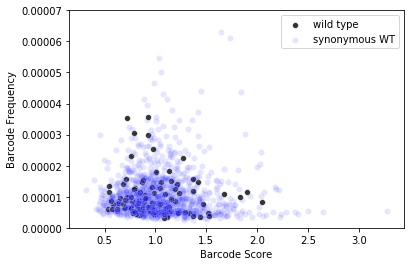

In [7]:
myplot = sns.scatterplot(data=data[data['AA Variant'] == "_wt"], 
                    x='mean dmso, WT normalized, BC level',
                    y='dmso barcode frequency',
                    alpha = 0.8,
                    color = 'black', 
                    label = 'wild type'
                    )

myplot = sns.scatterplot(data=data[data['AA Variant'] == "synon."], 
                    x='mean dmso, WT normalized, BC level',
                    y='dmso barcode frequency',
                    alpha = 0.1,
                    color = 'blue',
                    label = 'synonymous WT'
                    )

myplot.set(ylim=(0, 0.00007))
#myplot.set(xlim=(0.4, 1.6))
plt.xlabel('Barcode Score')
plt.ylabel('Barcode Frequency')

In [8]:
#Create dataframe to use to plot replicate pERK/Flag scores at the AA Variant Level
#-----------------------------------------------------------------------------------#
    
#Include only variants with 3 or more barcodes
Replicate_score_data = data[data ['Number of Barcodes/AA Var'] != 0]
Replicate_score_data = Replicate_score_data [Replicate_score_data ['Number of Barcodes/AA Var'] != 1]
Replicate_score_data = Replicate_score_data [Replicate_score_data ['Number of Barcodes/AA Var'] != 2]

#Group by AA Variant
Replicate_score_data = Replicate_score_data.groupby(['Label'])['dmso1, WT normalized, BC level', 
                                                               'dmso2, WT normalized, BC level',
                                                              ].mean()

#Rename columns
Replicate_score_data = Replicate_score_data.rename(columns={"dmso1, WT normalized, BC level": "dmso1, WT normalized, Variant level", 
                                                            "dmso2, WT normalized, BC level": "dmso2, WT normalized, Variant level",                                                                                                                                                                                
                                                           })

#Calculate Average score
Replicate_score_data['dmso_Average Score'] = (Replicate_score_data['dmso1, WT normalized, Variant level'] + Replicate_score_data['dmso2, WT normalized, Variant level'])/2

#Classify as GOF, LOF, or WT-like
#Define cutoff: Calculate SD of synonymous distribution and multiply by 2
dmso_cutoff = 2*(SynonDist_ratios['dmso_Average'].std())

for i,row in Replicate_score_data.iterrows():
    if row['dmso_Average Score'] > (1+dmso_cutoff):
        Replicate_score_data.at[i, 'DMSO Classification'] = 'GOF'
    elif row['dmso_Average Score'] < (1-dmso_cutoff):
        Replicate_score_data.at[i, 'DMSO Classification'] = 'LOF'
    else:
        Replicate_score_data.at[i, 'DMSO Classification'] = 'Wild Type-Like'
        

Replicate_score_data

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.


,"dmso1, WT normalized, Variant level","dmso2, WT normalized, Variant level",dmso_Average Score,DMSO Classification
Label,,,,
Ala305Asn,1.070176,0.861774,0.965975,Wild Type-Like
Ala305Cys,1.149676,0.864320,1.006998,Wild Type-Like
Ala305Gln,1.326459,1.119227,1.222843,GOF
Ala305Gly,1.187280,0.688390,0.937835,Wild Type-Like
Ala305His,1.057205,0.845748,0.951477,Wild Type-Like
...,...,...,...,...
Val600Thr,1.913804,2.017609,1.965707,GOF
Val600Trp,2.042374,1.641046,1.841710,GOF
Val600Tyr,1.974225,1.837463,1.905844,GOF


In [9]:
GOF_Cutoff = 1+dmso_cutoff
LOF_Cutoff = 1-dmso_cutoff

print(GOF_Cutoff)
print(LOF_Cutoff)

1.206015783846075
0.793984216153925


In [10]:
Replicate_score_data.to_csv('Activity with CRAF_Replicate Score Data_filter 0.0000_3BC minimum.tsv', sep='\t')

In [11]:
Replicate_score_data[Replicate_score_data['DMSO Classification'] == 'GOF'].to_csv('GOF activity variants.tsv', sep='\t')

In [12]:
WTlike = Replicate_score_data[Replicate_score_data['DMSO Classification'] == 'Wild Type-Like']
GOF = Replicate_score_data[Replicate_score_data['DMSO Classification'] == 'GOF']
LOF = Replicate_score_data[Replicate_score_data['DMSO Classification'] == 'LOF']

WTpercent = 100*(len(WTlike)/(len(WTlike) + len(GOF) + len(LOF)))
GOFpercent = 100*(len(GOF)/(len(WTlike) + len(GOF) + len(LOF)))
LOFpercent = 100*(len(LOF)/(len(WTlike) + len(GOF) + len(LOF)))

print('Number (percentage) Wild Type-Like Variants: ' + str(len(WTlike)) + '(' + str(WTpercent) + '%)')
print('Number (percentage) Gain of Function Variants: ' + str(len(GOF)) + '(' + str(GOFpercent) + '%)')
print('Number (percentage) Loss of Function Variants: ' + str(len(LOF)) + '(' + str(LOFpercent) + '%)')

Number (percentage) Wild Type-Like Variants: 971(64.56117021276596%)
Number (percentage) Gain of Function Variants: 506(33.6436170212766%)
Number (percentage) Loss of Function Variants: 27(1.795212765957447%)


LinregressResult(slope=0.8101569984715374, intercept=0.16801573056994457, rvalue=0.8786372816262931, pvalue=0.0, stderr=0.011360271501453254)


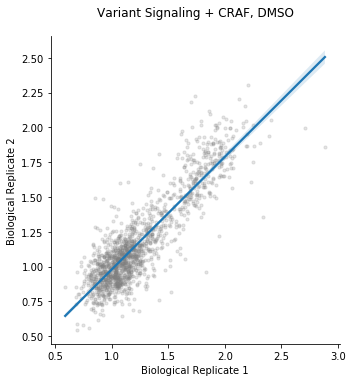

In [13]:
myplot = sns.lmplot(data=Replicate_score_data, 
                    x="dmso1, WT normalized, Variant level", 
                    y="dmso2, WT normalized, Variant level", 
                    scatter_kws={"color":"grey", "s": 10, "alpha":0.2}
                   )
plt.title("Variant Signaling + CRAF, DMSO", pad=20)
plt.xlabel('Biological Replicate 1')
plt.ylabel('Biological Replicate 2')


print(stats.linregress(Replicate_score_data["dmso1, WT normalized, Variant level"], 
                       Replicate_score_data["dmso2, WT normalized, Variant level"]))



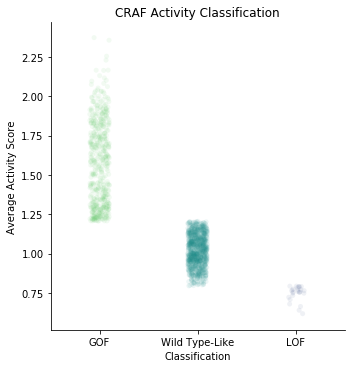

In [14]:
sns.catplot(
    data = Replicate_score_data,
    x = 'DMSO Classification',
    y = 'dmso_Average Score',
    order = ['GOF', 'Wild Type-Like', 'LOF'],
    palette = 'viridis_r',
    alpha = 0.08
)
plt.title('CRAF Activity Classification')
plt.xlabel('Classification')
plt.ylabel('Average Activity Score')

plt.savefig('pERK with CRAF_waterfall plot.svg')


# Heatmaps

In [15]:
#How many variants?

#Include only variants with 4 or more barcodes
check = data[data['Number of Barcodes/AA Var'] != 0]
check = check[check['Number of Barcodes/AA Var'] != 1]
check = check[check['Number of Barcodes/AA Var'] != 2]
check = check[check['Number of Barcodes/AA Var'] != 3]

#remove wild type data
check = check[check['Mutation'] != 'wild type or synon.']
check = check.groupby(['AA Variant'])['mean dmso, WT normalized, BC level'].mean().reset_index()


In [16]:
#Create dataframe to use in heatmap plotting

#Change mutation to single letter abbreviations
heatmap_data = data

for i, row in heatmap_data.iterrows():
    if row['Mutation'] == 'Arg':
        heatmap_data.at[i, 'Mutation'] = 'R'
    elif row['Mutation'] == 'His':
        heatmap_data.at[i, 'Mutation'] = 'H'
    elif row['Mutation'] == 'Lys':
        heatmap_data.at[i, 'Mutation'] = 'K'
    elif row['Mutation'] == 'Asp':
        heatmap_data.at[i, 'Mutation'] = 'D'
    elif row['Mutation'] == 'Glu':
        heatmap_data.at[i, 'Mutation'] = 'E'
    elif row['Mutation'] == 'Ser':
        heatmap_data.at[i, 'Mutation'] = 'S'
    elif row['Mutation'] == 'Thr':
        heatmap_data.at[i, 'Mutation'] = 'T'
    elif row['Mutation'] == 'Asn':
        heatmap_data.at[i, 'Mutation'] = 'N'
    elif row['Mutation'] == 'Gln':
        heatmap_data.at[i, 'Mutation'] = 'Q'
    elif row['Mutation'] == 'Cys':
        heatmap_data.at[i, 'Mutation'] = 'C'
    elif row['Mutation'] == 'Gly':
        heatmap_data.at[i, 'Mutation'] = 'G'
    elif row['Mutation'] == 'Pro':
        heatmap_data.at[i, 'Mutation'] = 'P'
    elif row['Mutation'] == 'Ala':
        heatmap_data.at[i, 'Mutation'] = 'A'
    elif row['Mutation'] == 'Val':
        heatmap_data.at[i, 'Mutation'] = 'V'
    elif row['Mutation'] == 'Ile':
        heatmap_data.at[i, 'Mutation'] = 'I'
    elif row['Mutation'] == 'Leu':
        heatmap_data.at[i, 'Mutation'] = 'L'
    elif row['Mutation'] == 'Met':
        heatmap_data.at[i, 'Mutation'] = 'M'
    elif row['Mutation'] == 'Phe':
        heatmap_data.at[i, 'Mutation'] = 'F'      
    elif row['Mutation'] == 'Tyr':
        heatmap_data.at[i, 'Mutation'] = 'Y'   
    elif row['Mutation'] == 'Trp':
        heatmap_data.at[i, 'Mutation'] = 'W' 
    elif row['Mutation'] == 'Ter':
        heatmap_data.at[i, 'Mutation'] = '*'    
    
#Include only variants with 4 or more barcodes
heatmap_data = heatmap_data[heatmap_data['Number of Barcodes/AA Var'] != 0]
heatmap_data = heatmap_data[heatmap_data['Number of Barcodes/AA Var'] != 1]
heatmap_data = heatmap_data[heatmap_data['Number of Barcodes/AA Var'] != 2]
heatmap_data = heatmap_data[heatmap_data['Number of Barcodes/AA Var'] != 3]


#remove wild type data
heatmap_data = heatmap_data[heatmap_data['Mutation'] != 'synonymous']
heatmap_data = heatmap_data[heatmap_data['Mutation'] != 'wild type']
heatmap_data = heatmap_data[heatmap_data['Mutation'] != 'BTK']

#restructure it to be in the correct form for a heatmap. Each value is the average ratio for that mutation
#at that position
heatmap_data_dmso = heatmap_data.groupby(['Position', 'Mutation'])['mean dmso, WT normalized, BC level'].mean().unstack()

#transpose data so ORF position is on the x-axis
heatmap_data_dmso= heatmap_data_dmso.transpose()

# Define the desired order of columns
desired_order = [26, 80, 102, 189, 192, 211, 257, 258, 262, 294, 305, 318, 326, 332, 334, 341, 345, 347, 367, 385, 389, 443, 444, 447, 449, 453, 456, 462, 464, 466, 467, 468, 469, 471, 472, 485, 499, 501, 509, 518, 531, 539, 574, 581, 582, 584, 586, 587, 588, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 604, 605, 606, 608, 609, 614, 615, 616, 618, 636, 666, 671, 682, 695, 725, 726, 727, 735, 762]
desired_order = [str(value) for value in desired_order]

# Reorder the columns based on the desired order
heatmap_data_dmso = heatmap_data_dmso[desired_order]

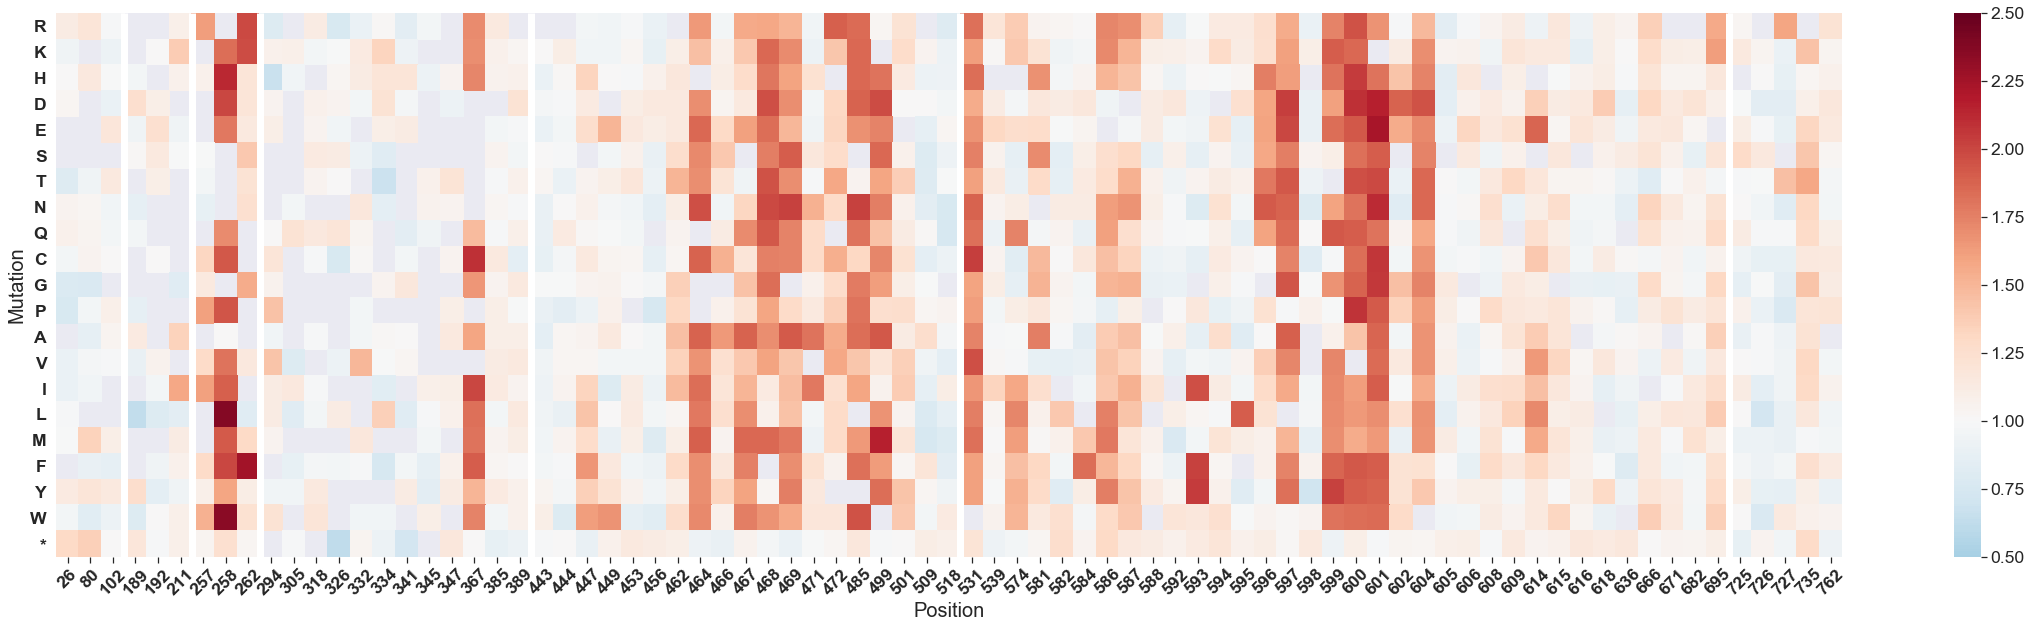

In [17]:
import matplotlib.colors as mcolors
import matplotlib as mpl

sns.set(font_scale=1.6)

orders = ['R' ,'K', 'H', 'D', 'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P', 'A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W', '*']

plt.figure(figsize = (40,10))

# Reindex data
reindexed_data = heatmap_data_dmso.reindex(orders, axis=0)

# Create a mask for NaN values
mask = reindexed_data.isna()

# Create a custom colormap for NaN values and another one for the actual data
cmap_nan = mcolors.ListedColormap(['black'])
cmap_data = plt.cm.RdBu_r

# Plot NaN values with specific color
sns.heatmap(reindexed_data, mask=~mask, cmap=cmap_nan, cbar=False)

# Plot the rest of the data with the original colormap
ax = sns.heatmap(reindexed_data, mask=mask, cmap=cmap_data, vmin=0.5, vmax=2.5, center=1)

#plt.title('Activity+CRAF Scores', fontsize = 30)
plt.xlabel('Position', fontsize = 20, fontname='Sans Serif')
plt.ylabel('Mutation', fontsize = 20, fontname='Sans Serif')
plt.yticks(rotation=0)
plt.xticks(rotation=45)

# Make tick labels bold
for label in plt.gca().get_yticklabels():
    label.set_fontweight('bold')
    label.set_fontname('Sans Serif')
    
for label in plt.gca().get_xticklabels():
    label.set_fontweight('bold')
    label.set_fontname('Sans Serif')
    
plt.tick_params(left=False, bottom=True) ## other options are right and top
ax.vlines([3, 6, 9, 21, 40, 74], *ax.get_ylim(), linewidth=7, color = 'white')



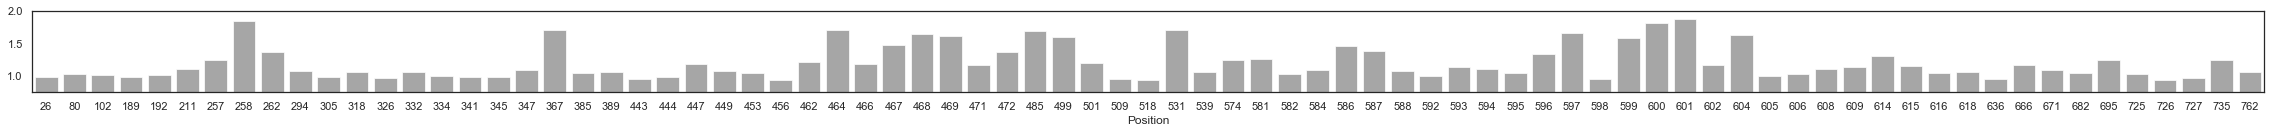

In [18]:
sns.set(font_scale=1.0)
sns.set(style='white')

# Calculate the average values at each position
avg_values = heatmap_data.groupby(['Position', 'Mutation'])['mean dmso, WT normalized, BC level'].mean().reset_index()
avg_values = avg_values.groupby(['Position'])['mean dmso, WT normalized, BC level'].mean()

# Define the desired order of columns
desired_order = [
                 #8, 
                 26, 80, 102, 189, 192, 211, 257, 258, 262, 294, 305, 318, 326, 332, 334, 341, 345, 347, 367, 385, 389, 443, 444, 447, 449, 453, 456, 462, 464, 466, 467, 468, 469, 471, 472, 485, 499, 501, 509, 518, 531, 539, 574, 581, 582, 584, 586, 587, 588, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 604, 605, 606, 608, 609, 614, 615, 616, 618, 636, 666, 671, 682, 695, 725, 726, 727, 735, 762]
desired_order = [str(value) for value in desired_order]

plt.figure(figsize = (40,1.5))

#Plot the barplot
sns.barplot(x=avg_values.index, y=avg_values.values, color='gray', alpha=0.7, 
            orient='v', 
            ci=None,
            order = desired_order,
            #width = 1.0,
           )


#Change ylimit
plt.ylim(0.75, 2)

plt.savefig('Activity with CRaf Bar Plot.svg')

In [21]:
select = heatmap_data[heatmap_data['Mutation'] != '*']

avg_values1 = select.groupby(['Position', 'Mutation'])['mean dmso, WT normalized, BC level'].mean().reset_index()
avg_values1 = avg_values1.groupby(['Position'])['mean dmso, WT normalized, BC level'].mean().reset_index()
avg_values1.reset_index().sort_values('mean dmso, WT normalized, BC level').to_csv('Activity with CRaf_Position mean.tsv', sep='\t')

avg_values2 = select.groupby(['Position', 'Mutation'])['mean dmso, WT normalized, BC level'].mean().reset_index()
avg_values2 = avg_values2.groupby(['Position'])['mean dmso, WT normalized, BC level'].median().reset_index()
avg_values2.reset_index().sort_values('mean dmso, WT normalized, BC level').to_csv('Activity with CRaf_Position median.tsv', sep='\t')

avg_values2


,Position,"mean dmso, WT normalized, BC level"
0,102,0.991546
1,189,0.946515
2,192,1.008030
3,211,1.081342
4,257,1.290475
...,...,...
74,726,0.947521
75,727,0.887598
76,735,1.250798
77,762,1.068509


## Histograms

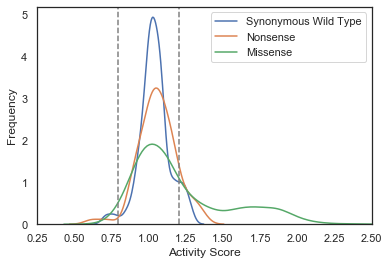

In [15]:
#Plot non-synonymous and synonymous distributions

#sns.set(font_scale=1.0)
sns.set(style='white')

synonVar = SynonDist_ratios['dmso_Average'].to_list()
sns.distplot(synonVar, bins = 30, axlabel='pERK/Flag Score', hist=False, label = 'Synonymous Wild Type')

nonsenseScores = []
missenseScores = []

for i, row in Replicate_score_data.iterrows():
    var = str(i)
    score = row['dmso_Average Score']
    if "Ter" in var:
        nonsenseScores.append(score)
    elif "synon." in var:
        continue
    elif "_wt" in var:
        continue
    elif "BTK" in var:
        continue
    else:
        missenseScores.append(score)
        
sns.distplot(nonsenseScores, bins = 30, axlabel='pERK/Flag Score', hist=False, label = 'Nonsense')
sns.distplot(missenseScores, bins = 1000, axlabel='pERK/Flag Score', hist=False, label = 'Missense')
plt.axvline(x=GOF_Cutoff, color = 'gray', linestyle = 'dashed')
plt.axvline(x=LOF_Cutoff, color = 'gray', linestyle = 'dashed')

plt.xlim([0.25, 2.5])
#plt.ylim([0,13])
plt.ylabel('Frequency')
plt.xlabel('Activity Score')

plt.savefig('pERK with CRAF_distributions.svg')

# Cat Plots

In [65]:
#Reset index
catplot_data = Replicate_score_data.reset_index()
catplot_data = catplot_data[catplot_data['Label'] != 'wild type or synon.']
catplot_data = catplot_data[catplot_data['Label'] != 'BTK']

#Create list that can be used to determnine order on catplot
    
positionList = [8, 26, 80, 102, 189, 192, 211, 257, 258, 262, 294, 305, 318, 326, 332, 334, 341, 345, 347, 367, 385, 389, 443, 444, 447, 449, 453, 456, 462, 464, 466, 467, 468, 469, 471, 472, 485, 499, 501, 509, 518, 531, 539, 574, 581, 582, 584, 586, 587, 588, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 604, 605, 606, 608, 609, 614, 615, 616, 618, 636, 666, 671, 682, 695, 725, 726, 727, 735, 762]

#Add a column containing WT residue, position, and mutation
for i, row in catplot_data.iterrows():
    if len(str(row['Label']))==9:
        catplot_data.at[i, 'Wild Type Residue'] = str(row['Label'])[:3]
        catplot_data.at[i, 'Mutation'] = str(row['Label'])[6:]
        position = str(row['Label'])[3:6]
        catplot_data.at[i, 'Position'] = str(position)
    elif len(str(row['Label']))==8:
        catplot_data.at[i, 'Wild Type Residue'] = str(row['Label'])[:3]
        catplot_data.at[i, 'Mutation'] = str(row['Label'])[5:]
        position = str(row['Label'])[3:5]
        catplot_data.at[i, 'Position'] = str(position)
    elif len(str(row['Label']))==10:
        catplot_data.at[i, 'Wild Type Residue'] = str(row['Label'])[:3]
        catplot_data.at[i, 'Mutation'] = str(row['Label'])[7:]
        position = str(row['Label'])[3:7]
        catplot_data.at[i, 'Position'] = str(position)
        
#Add a column containing WT residue + position
for i, row in catplot_data.iterrows():
    wildtype = str(row['Wild Type Residue'])
    position = str(row['Position'])
    label = wildtype + position
    catplot_data.at[i, 'Catplot Label'] = label

#Add column classifying amino acid charge type and branching

catplot_data['Mutation Charge Type'] =''
positive = ['Arg', 'Lys', 'His']
negative = ['Asp', 'Glu']
nocharge = ['Ser', 'Thr', 'Asn', 'Gln', 'Cys', 'Gly', 'Pro']
hydrophobic = ['Ala', 'Val', 'Ile', 'Leu', 'Met', 'Phe', 'Tyr', 'Trp']
betaBranched = ['Ile', 'Leu', 'Val']
selects = ['367', '485', '574', '682']
selectMuts = ['Pro367Arg', 'Leu485Ser','His574Gln', 'Arg682Trp']
    
for i, row in catplot_data.iterrows():
    mutation = str(row['Mutation'])
    if mutation in positive:
        type = 'Positively Charged'
    elif mutation in negative:
        type = 'Negatively Charged'
    elif mutation in nocharge:
        type = 'Not Charged'
    elif mutation in hydrophobic:
        type = 'Hydrophobic'
    else:
        type = 'Not Classified'
    catplot_data.at[i, 'Mutation Charge Type'] = type

for i, row in catplot_data.iterrows():
    mutation = str(row['Mutation'])
    if mutation in betaBranched:
        type = 'Branched'
    else:
        type = 'Not Branched'  
    catplot_data.at[i, 'Mutation Branching'] = type

for i, row in catplot_data.iterrows():
    position = str(row['Position'])
    variant = str(row['Label'])
    if position in selects:
        type = 'Yes'
        if variant in selectMuts:
            type2 = 'Yes'
            catplot_data.at[i, 'DMSO Classification'] = 'Tumor Promoter'
        else:
            type2 = 'Not Observed'
    else:
        type = 'Not Observed'
        type2 = 'Not Observed'
    catplot_data.at[i, 'tumor growth position'] = type
    catplot_data.at[i, 'tumor growth mutation'] = type2

taggedList = ['36', '54', '108', '130', '217', '220', '239', '285', '286', '290', '322', '333', '346', '354', '360', '362', 
 '369', '373', '375', '395', '413', '417', '471', '472', '475', '477', '481', '484', '490', '492', '494', '495', 
 '496', '497', '499', '500', '513', '527', '529', '537', '546', '559', '567', '602', '609', '610', '612', '614', '615', 
 '616', '620', '621', '622', '623', '624', '625', '626', '627', '628', '629', '630', '632', '633', '634', '636', '637', 
 '642', '643', '644', '646', '664', '694', '699', '710', '723', '753', '754', '755', '763', '790']
    
untaggedList = []
for residue in taggedList:
    untagged = int(residue) - 28
    untagged = str(untagged)
    untaggedList.append(untagged)

catplot_data



,Label,"dmso1, WT normalized, Variant level","dmso2, WT normalized, Variant level",dmso_Average Score,DMSO Classification,Wild Type Residue,Mutation,Position,Catplot Label,Mutation Charge Type,Mutation Branching,tumor growth position,tumor growth mutation
0,Ala305Asn,1.070176,0.861774,0.965975,Wild Type-Like,Ala,Asn,305,Ala305,Not Charged,Not Branched,Not Observed,Not Observed
1,Ala305Cys,1.149676,0.864320,1.006998,Wild Type-Like,Ala,Cys,305,Ala305,Not Charged,Not Branched,Not Observed,Not Observed
2,Ala305Gln,1.326459,1.119227,1.222843,GOF,Ala,Gln,305,Ala305,Not Charged,Not Branched,Not Observed,Not Observed
3,Ala305Gly,1.187280,0.688390,0.937835,Wild Type-Like,Ala,Gly,305,Ala305,Not Charged,Not Branched,Not Observed,Not Observed
4,Ala305His,1.057205,0.845748,0.951477,Wild Type-Like,Ala,His,305,Ala305,Positively Charged,Not Branched,Not Observed,Not Observed
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499,Val600Thr,1.913804,2.017609,1.965707,GOF,Val,Thr,600,Val600,Not Charged,Not Branched,Not Observed,Not Observed
1500,Val600Trp,2.042374,1.641046,1.841710,GOF,Val,Trp,600,Val600,Hydrophobic,Not Branched,Not Observed,Not Observed
1501,Val600Tyr,1.974225,1.837463,1.905844,GOF,Val,Tyr,600,Val600,Hydrophobic,Not Branched,Not Observed,Not Observed
1502,_wt,1.000000,1.000000,1.000000,Wild Type-Like,NaN,NaN,NaN,nannan,Not Classified,Not Branched,Not Observed,Not Observed


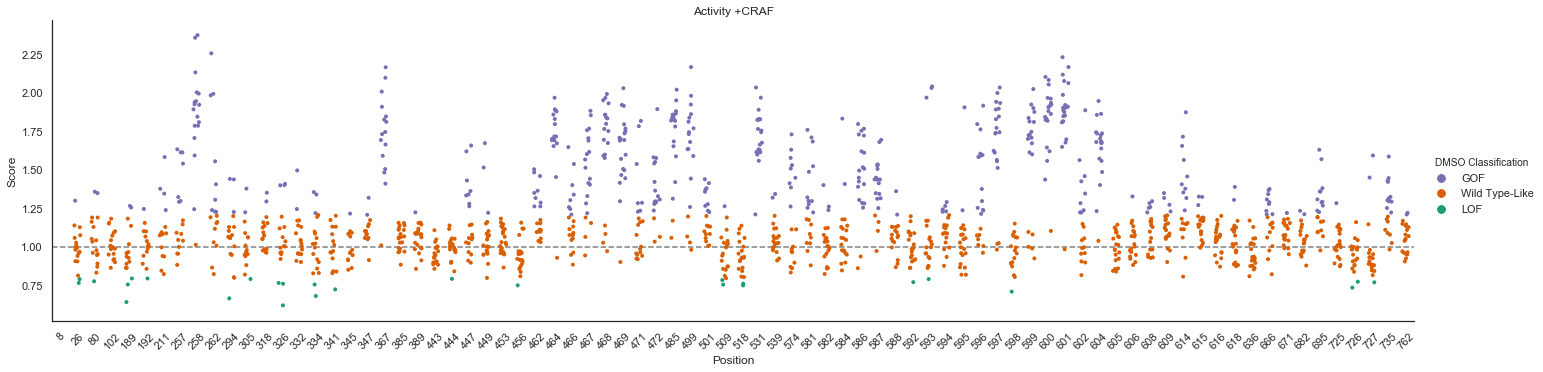

In [66]:
myplot = sns.catplot(
    data = catplot_data,
    x = 'Position',
    y = 'dmso_Average Score',
    height = 5,
    aspect = 4,
    jitter = 0.2,
    s = 4,
    hue = 'DMSO Classification',
    hue_order = ['GOF', 'Wild Type-Like', 'LOF'],
    palette = sns.color_palette(['#7570b3', '#d95f02', '#1b9e77']),
    order = untaggedList

)
#plt.ylim(0, 5)
plt.xticks(rotation=45)
plt.ylabel('Score')
plt.xlabel('Position')
plt.title('Activity +CRAF')
plt.axhline(1.0, color = 'grey', linestyle = 'dashed') #Wild type score

plt.savefig('pERK with CRAF_Catplot.svg')